In [166]:
import pylab
import matplotlib as mpl
import pandas as pd
import scipy as scp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import UnivariateSpline
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 18})

#new stuff
from scipy.stats import friedmanchisquare
from scipy.stats import chisqprob

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


<h3> This loads in the data </h3>

In [2]:
#Ani=pd.read_excel('/Users/attiladobi/Documents/Ani/sept_oct2013.xlsx',skiprows=0)
Ani=pd.read_excel('data/sept_oct2013.xlsx',skiprows=0)
Time=array(Ani['Time'].T,dtype='datetime64')
Ani['Hour']=pd.DatetimeIndex(Ani['Time']).hour #sort by hours of the day

In [19]:
pd.DatetimeIndex(Ani['Time']).hour

array([10, 10, 10, ...,  9,  9,  9], dtype=int32)

<h1> List the available keys </h1>

In [95]:
Ani.keys()

Index([ u'Time',   u'TS2',   u'HS2',   u'DS2',  u'TSh6',  u'HSh6',  u'DSh6',
        u'TSh7',  u'HSh7',  u'DSh7',  u'TS10',  u'HS10',  u'DS10', u'TSh16',
       u'HSh16', u'DSh16', u'TSh17',  u'Sh17', u'DSh17',  u'TS19',  u'HS19',
        u'DS19', u'TSh19', u'HSh19', u'DSh19',  u'TS27',  u'HS27',  u'DS27',
        u'TS29',  u'HS29',  u'DS29',  u'TS32',  u'HS32',  u'DS32', u'TSh33',
       u'HSh33', u'DSh33',  u'TS34',  u'HS34',  u'DS34', u'TSh35', u'HSh35',
       u'DSh35',  u'TS37',  u'HS37',  u'DS37', u'TSh42', u'HSh42', u'DSh42',
         u'TK5',   u'HK5',   u'DK5',   u'TK8',   u'HK8',   u'DK8',  u'Hour'],
      dtype='object')

In [42]:
a=np.arange(0,24)
print(a)
a[0:3]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


array([0, 1, 2])

<h1> Pull out temperature data sorted by hour for plotting </h1>

In [70]:
vals_hour=[]
hours=np.arange(0,24)
for hour in hours:
    vals=[]
    for key in Ani.keys():
        if (key[0:2]=='TK') | (key[0:2]=='TS'):
            vals.append(Ani[key].loc[Ani['Hour']==hour].mean())
            #print(key,Ani[key].loc[Ani['Hour']==hour].mean())
    vals.reverse()
    vals_hour.append(vals)
#vals_hour
savetxt('data/Ani_temp.txt',vals_hour)

<h1> Convert list to array and select on back sun sensors, then plot :p </h1>

In [71]:
array_hour=np.array(vals_hour)

In [73]:
array_hour.shape

(24, 18)

In [81]:
array_hour[:,4] #list all hours for last temperature sensor

array([  9.50064103,   8.52115385,   7.71538462,   6.83846154,
         6.21730769,   5.93966713,   5.41136364,   6.04772727,
        10.84393939,  14.36515152,  19.12564103,  23.56089744,
        26.73477673,  29.36388889,  30.56597222,  30.60972222,
        29.74652778,  28.29027778,  27.05277778,  23.18611111,
        18.86730769,  16.14679487,  13.68910256,  11.29102564])

In [97]:
TS_back_ave=mean(array_hour[:,[-1,-4,-7]],1) #take the mean over the three sensors
TS_front_ave=mean(array_hour[:,[4,6,8,9,10]],1) #take the mean over the three sensors

(0, 23)

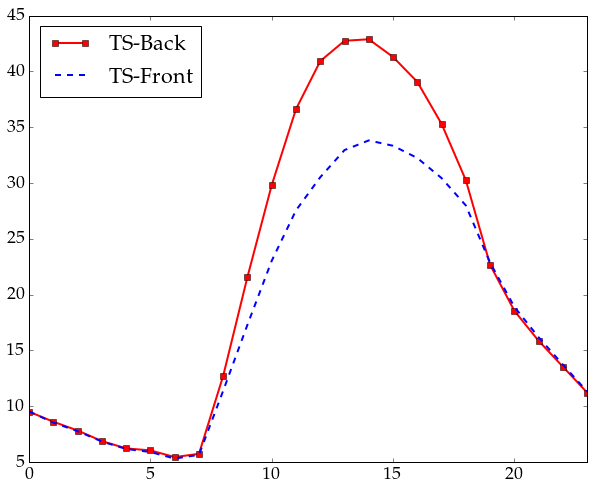

In [102]:
hour=np.arange(0,24) #makes the x axis, we use 0-23 for time on the plot.
plt.plot(hour,TS_back_ave,'s-r',linewidth=2) #TS2, TS10, TS19. We reversed the order. -1 is index TS2
plt.plot(hour,TS_front_ave,'--b') #front sensor
plt.legend(('TS-Back','TS-Front'),loc='upper left') #add lables and location on the plot
xlim(0,23) #sets the x-limits on the plot

<h1> Pull out humidity data sorted by hour for plotting </h1>

In [7]:
vals_hum_hour=[]
hours=np.arange(0,24)
for hour in hours:
    vals=[]
    for key in Ani.keys():
        if (key[0:2]=='HK') | (key[0:2]=='HS'):
            vals.append(Ani[key].loc[Ani['Hour']==hour].mean())
            #print(key,Ani[key].loc[Ani['Hour']==hour].mean())
    vals.reverse()
    vals_hum_hour.append(vals)
savetxt('data/Ani_hum.txt',vals_hum_hour)

<h1> Get dewpoint data by the hour </h1>

In [8]:
vals_dew_hour=[]
hours=np.arange(0,24)
for hour in hours:
    vals=[]
    for key in Ani.keys():
        if (key[0:2]=='DK') | (key[0:2]=='DS'):
            vals.append(Ani[key].loc[Ani['Hour']==hour].mean())
            #print(key,Ani[key].loc[Ani['Hour']==hour].mean())
    vals.reverse()
    vals_dew_hour.append(vals)
savetxt('data/Ani_dew.txt',vals_dew_hour)

<h1> Plot the means of Sun and shade vs. time of day </h1>

In [157]:
def get_ave_values(str1='T'):
    shade_ave_all=[]
    sun_ave_front=[]
    sun_ave_back=[]
    con_ave_all=[]
    shade_std_all=[]
    sun_std_front=[]
    sun_std_back=[]
    con_std_all=[]
    hours=np.arange(0,24)
    for hour in hours:
        means_sun_back=[]
        means_sun_front=[]
        means_shade=[]
        means_con=[]
        for key in Ani.keys():
            if (key[0:3]==str1+'Sh'):
                means_shade.append(Ani[key].loc[Ani['Hour']==hour].mean())
                #print(key,Ani[key].loc[Ani['Hour']==hour].mean())
            elif ((key[0:3]==str1+'S2') | (key[0:4]==str1+'S10') | (key[0:4]==str1+'S19') ) :
                means_sun_back.append(Ani[key].loc[Ani['Hour']==hour].mean())
            elif (key[0:2]==str1+'S'):
                means_sun_front.append(Ani[key].loc[Ani['Hour']==hour].mean())
            elif (key[0:2]==str1+'K'):
                means_con.append(Ani[key].loc[Ani['Hour']==hour].mean())
        shade_ave_all.append(mean(means_shade))
        shade_std_all.append(std(means_shade))
        sun_ave_back.append(mean(means_sun_back))
        sun_std_back.append(std(means_sun_back))
        sun_ave_front.append(mean(means_sun_front))
        sun_std_front.append(std(means_sun_front))
        con_ave_all.append(mean(means_con))
        con_std_all.append(std(means_con))
    return sun_ave_back, sun_std_back, sun_ave_front, sun_std_front, shade_ave_all, shade_std_all, con_ave_all, con_std_all

<h1> Test hypothosis that three independent measurements are the same. Here we select the time range </h1>

In [158]:
sun_ave_back, sun_std_back, sun_ave_front, sun_std_front, shade_ave_all, shade_std_all, con_ave_all, con_std_all = get_ave_values('T')

In [197]:
start_h=8
end_hour=14
hour_diff=end_hour-start_h 

sun_back_test=np.array([])
sun_front_test=np.array([])
shade_test=np.array([])
cont_test=np.array([])
std_sun_back_test=np.array([])
std_sun_front_test=np.array([])
std_shade_test=np.array([])
std_cont_test=np.array([])


for hour in range(start_h,end_hour):
    sun_back_test= hstack((sun_back_test,sun_ave_back[hour]))
    sun_front_test= hstack((sun_front_test,sun_ave_front[hour]))
    shade_test= hstack((shade_test,shade_ave_all[hour]))
    cont_test= hstack((cont_test,con_ave_all[hour]))
    #get std
    std_sun_back_test= hstack((std_sun_back_test,sun_std_back[hour]))
    std_sun_front_test= hstack((std_sun_front_test,sun_std_front[hour]))
    std_shade_test= hstack((std_shade_test,shade_std_all[hour]))
    std_cont_test= hstack((std_cont_test,con_std_all[hour]))


('chi^2 =', 9.3333333333333286, ' p= ', 0.0094035625514952304)


<h1> Friedman test... Testing weather or not three independent measurements are consistent with each other </h1>

In [198]:
# here we test the mean of sun_back, sun_front, and the control averaged over hour
chi2, p = friedmanchisquare(sun_back_test,sun_front_test,cont_test)
print ('chi^2 =',chi2,' p= ', p)

#if we want to test the difference between only two measurements have to use a chi^2 test taking one as the theory and the other as the experiment:
#the degrees of freedom are the number of data points - 1 for the averaging. Form that you can calulate the p value.

('chi^2 =', 9.3333333333333286, ' p= ', 0.0094035625514952304)


<h2> let's do a Chi^2 test between the sun_back and sun_front. Fine in limit of average over 1000+ data points where the central value and standard deviation are well defined </h2>

In [196]:
#take the sun back as the experiment and sun_front as the theoretical expectation
#method: X^2 = sum( ((Fe-Ft)^2/sigma)^2 )

chi2= sum( (sun_front_test-sun_back_test)**2/(std_sun_back_test**2 + std_sun_front_test**2) )
p_val = chisqprob(chi2, hour_diff-1)

print('chi^2 =', chi2, ' p value of chi^2 test = ', p_val)

('chi^2 =', 15.463033247968475, ' p value of chi^2 test = ', 0.0085566858485583343)


<h1> Plot the sun data broken down by hour and sensor type </h1>

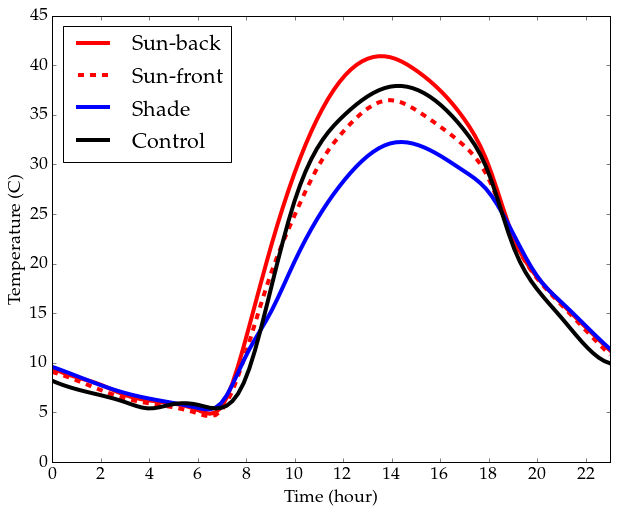

In [119]:
sun_ave_back, sun_ave_front, shade_ave_all, con_ave_all = get_ave_values('T')

#spline interpolation to the data
xhours=linspace(0,23,100)
SS_back= UnivariateSpline(hours,sun_ave_back,s=0.1)
SS_front= UnivariateSpline(hours,sun_ave_front,s=0.1)
SSh= UnivariateSpline(hours,shade_ave_all,s=0.1)
SC= UnivariateSpline(hours,con_ave_all,s=0.1)

######### plot with spline interpolation #########
plot(xhours,SS_back(xhours),'-r',linewidth=4)
plot(xhours,SS_front(xhours),'--r',linewidth=4)
plot(xhours,SSh(xhours),'-b',linewidth=4)
plot(xhours,SC(xhours),'-k',linewidth=4)

######### plot without spine  #############
#plot(hours,sun_ave_back,'-r',linewidth=4)
#plot(hours,sun_ave_front,'--r',linewidth=4)
#plot(hours,shade_ave_all,'-b',linewidth=4)
#plot(hours,con_ave_all,'-k',linewidth=4)

ylabel('Temperature (C)')
xlabel('Time (hour)')
legend(('Sun-back','Sun-front','Shade','Control'),loc='upper left')
xticks(np.arange(0,23,2))
xlim(0,23)
plt.savefig('fig/temp_means.png')

<h1> Humidity </h1>

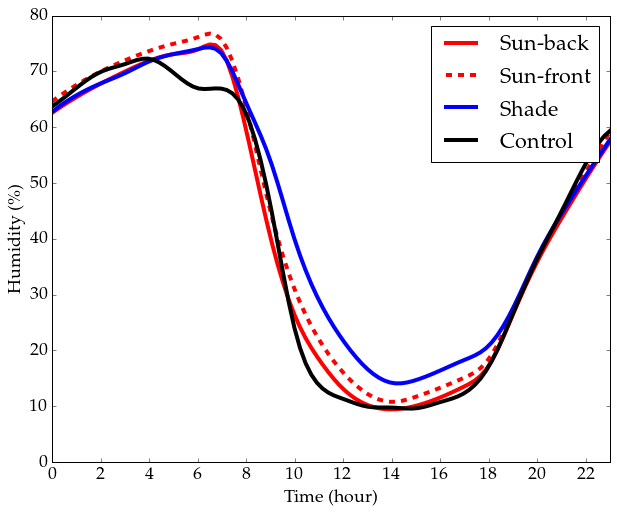

In [121]:
sun_ave_back, sun_ave_front, shade_ave_all, con_ave_all = get_ave_values('H')

#spline interpolation to the data
xhours=linspace(0,23,100)
SS_back= UnivariateSpline(hours,sun_ave_back,s=0.1)
SS_front= UnivariateSpline(hours,sun_ave_front,s=0.1)
SSh= UnivariateSpline(hours,shade_ave_all,s=0.1)
SC= UnivariateSpline(hours,con_ave_all,s=0.1)

######### plot with spline interpolation #########
plot(xhours,SS_back(xhours),'-r',linewidth=4)
plot(xhours,SS_front(xhours),'--r',linewidth=4)
plot(xhours,SSh(xhours),'-b',linewidth=4)
plot(xhours,SC(xhours),'-k',linewidth=4)

ylabel('Humidity (\%)')
xlabel('Time (hour)')
legend(('Sun-back','Sun-front','Shade','Control'),loc='upper right')
xticks(np.arange(0,23,2))
xlim(0,23)
plt.savefig('fig/hum_means.png')

<h1> Dew Point </h1>

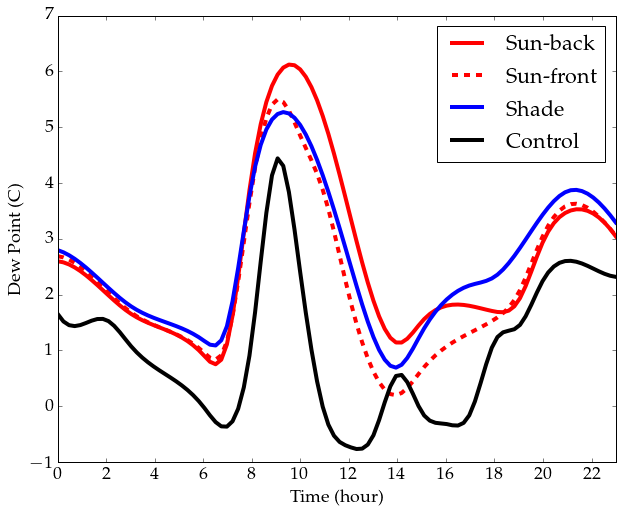

In [123]:
sun_ave_back, sun_ave_front, shade_ave_all, con_ave_all = get_ave_values('D')

#spline interpolation to the data
xhours=linspace(0,23,100)
SS_back= UnivariateSpline(hours,sun_ave_back,s=0.1)
SS_front= UnivariateSpline(hours,sun_ave_front,s=0.1)
SSh= UnivariateSpline(hours,shade_ave_all,s=0.1)
SC= UnivariateSpline(hours,con_ave_all,s=0.1)

######### plot with spline interpolation #########
plot(xhours,SS_back(xhours),'-r',linewidth=4)
plot(xhours,SS_front(xhours),'--r',linewidth=4)
plot(xhours,SSh(xhours),'-b',linewidth=4)
plot(xhours,SC(xhours),'-k',linewidth=4)

ylabel('Dew Point (C)')
xlabel('Time (hour)')
legend(('Sun-back','Sun-front','Shade','Control'),loc='upper right')
xticks(np.arange(0,23,2))
xlim(0,23)
plt.savefig('fig/dew_means.png')